In [2]:
import math
import random
import numpy as np
from collections import deque
import time

import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation as FrameStack

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple, deque

import ale_py

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
frames_stacked = 4


gym.register_envs(ale_py)
env = FrameStack(gym.make("ALE/Pong-v5"), frames_stacked)

num_actions = env.action_space.n
frame_shape = env.observation_space.shape 

In [5]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_outputs = num_outputs
    
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_output_len = int(np.prod(self.conv_layers(torch.zeros(1, *input_shape)).size()))
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_len, 120),
            nn.ReLU(),
            nn.Linear(120, self.num_outputs)
        )
    
    def forward(self, x):
        conv_out = self.conv_layers(x).view(x.size()[0], -1)
        return self.fc_layers(conv_out)

In [6]:
def preprocess(frame):
    processed = np.mean(np.array(frame)/255.0,3, np.float32, keepdims = False, )
    cropped = processed[:,32:198,8:-8]
    result = cropped[:,::2,::2]
    return torch.from_numpy(result).float().to(device)

args = env.reset()
state = args[0]
MAXLIVES = args[-1]['lives']

input_shape = preprocess(state).shape

input_shape

args = env.reset()
state = args[0]
MAXLIVES = args[-1]['lives']

input_shape = preprocess(state).shape

input_shape

torch.Size([4, 83, 72])

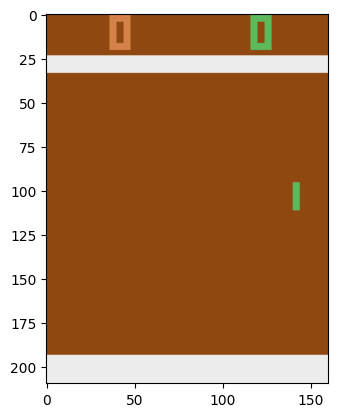

In [7]:
for _ in range(10): state, *_ = env.step(1)
plt.imshow(state[0])

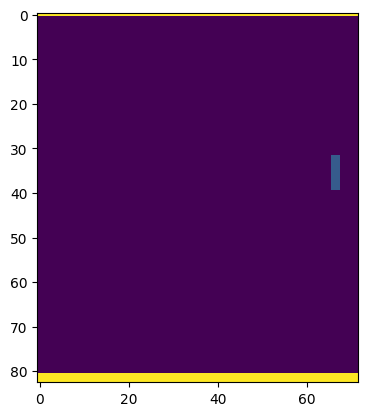

In [8]:
plt.imshow(preprocess(state)[0])

In [293]:
model = DQN(input_shape=input_shape, num_outputs=num_actions).to(device)

# Create policy and target network.
policy_net = DQN(input_shape=input_shape, num_outputs=num_actions).to(device)
target_net = DQN(input_shape=input_shape, num_outputs=num_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

with torch.no_grad():
    policy_net(preprocess(state).unsqueeze(0))

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity, batchSize):
        self.maxCapacity = capacity
        self.stateMemory = []
        self.actionMemory = []
        self.rewardMemory = []
        self.nextStateMemory = []
        self.batchSize = batchSize
        self.currentMemorySize = 0

    def push(self, state, action, reward, nextState):
        self.stateMemory.append(state)
        self.actionMemory.append(action)
        self.rewardMemory.append(reward)
        self.nextStateMemory.append(nextState)

        self.currentMemorySize += 1

        if(self.currentMemorySize > self.maxCapacity):
            self.stateMemory.pop(0)
            self.actionMemory.pop(0)
            self.rewardMemory.pop(0)
            self.nextStateMemory.pop(0)


    def sample(self):
        return random.sample(range(self.currentMemorySize), self.batchSize)

    def replay(self):

        if(self.currentMemorySize < self.batchSize): return

        minibatchIndices = self.sample()



        stateBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.stateMemory))).to(device)
        actionBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.actionMemory))).to(device)
        rewardBatch = torch.cat(list(itemgetter(*minibatchIndices)(self.actionMemory))).to(device).squeeze(1)


        nextStateBatchList = list(itemgetter(*minibatchIndices)(self.nextStateMemory))
        nonFinalNextStates = []
        nonFinalIndices = []

        for s in nextStateBatchList:
            if s is not None:
                nonFinalNextStates.append(s)
                nonFinalIndices.append(True)

            else:
                nonFinalIndices.append(False)

        nonFinalNextStates = torch.cat(nonFinalNextStates).to(device)

        nonFinalNextStateValues = torch.zeros(self.batchSize, device=device)
        nonFinalIndices = torch.tensor(tuple(nonFinalIndices), device=device, dtype=torch.bool)



        state_action_values = policy_net(stateBatch).gather(1, actionBatch)

        with torch.no_grad():
            nonFinalNextStateValues[nonFinalIndices] = target_net(nonFinalNextStates).max(1).values

        # Compute the expected Q values
        expected_state_action_values = (nonFinalNextStateValues*gamma) + rewardBatch


        # Compute Huber loss
        optimiser.zero_grad()
        criterion = nn.SmoothL1Loss()

        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        #loss.requires_grad = True
        loss.backward()
        # Register backward hook
        for p in policy_net.parameters(): p.grad.data.clamp_(-1, 1)
        optimiser.step()

In [294]:
# Hyperparameters
alpha = 1e-4  # learning rate
gamma = 0.99 # Discount fator

# Optimiser and loss function
optimiser = optim.Adam(policy_net.parameters(), lr=alpha, amsgrad=True)

# Epsilon
epsilon = 0.9
decay = 0.995

In [267]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))
class ReplayMemory(object):

    def __init__(self, capacity, batchSize):
        self.maxCapacity = capacity
        self.memory = deque([], maxlen=capacity)
        self.batchSize = batchSize

    def push(self, state, action, reward, nextState, done):
        if(done): return        
        self.memory.append(Transition(state, action, reward, nextState))

    def sample(self):
        return random.sample(self.memory, self.batchSize)

    def replay(self):
        
        if(len(self.memory) < self.batchSize): return 
        
        minibatch = self.sample()
        
        batch = Transition(*zip(*minibatch))


        non_final_next_states = torch.cat([s for s in batch.next_state])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

    
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        with torch.no_grad():
            next_state_values = target_net(non_final_next_states).max(1).values
            
        # Compute the expected Q values
        expected_state_action_values = (next_state_values*gamma) + reward_batch

        # Compute Huber loss

        optimiser.zero_grad()
        criterion = nn.HuberLoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        #loss.requires_grad = True
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimiser.step()
        
        

In [ ]:
# Replay memory parameters
capacity = 1000
batchSize = 32
memory = ReplayMemory(capacity=capacity, batchSize=batchSize)

In [ ]:
episodes = 10000 
verbose = True
steps = 0
verboseEpisode = 100
updateRate = 10
timesteps = 0
TAU = 0.005


for episode in range(episodes):
    state = env.reset()[0]
    state, reward, terminated, truncated, info = env.step(1)
    rewards = 0
    terminated, truncated = False, False
    state = preprocess(state).unsqueeze(0)
    


    while not terminated and not truncated and info['lives'] == 5:
        
        # Epsilon
        #epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-steps / EPS_DECAY)
        steps += 1
        
        # Explore
        if(random.uniform(0,1) <= epsilon): action = torch.tensor([[env.action_space.sample()]])
        
        # Exploit
        else:
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.max(1).indices.view(1, 1)
       
        nextState, reward, terminated, truncated, info = env.step(action.item())
        nextState = preprocess(nextState).unsqueeze(0)
        
        if(terminated or truncated or info['lives'] < 5): nextState = False
        
        memory.push(state, action,torch.tensor([max(reward,1)], device=device) , nextState, terminated or truncated or info['lives'] < 5)
        rewards += reward
        memory.replay()
        
        state = nextState
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if epsilon > 0.05:
            epsilon *= decay
    
    


    if(verbose and episode%verboseEpisode == 0): print(f"Episode: {episode}, Total Reward: {rewards}")

Episode: 0, Total Reward: 0.0
Episode: 100, Total Reward: 0.0
Episode: 200, Total Reward: 0.0
Episode: 300, Total Reward: 0.0
Episode: 400, Total Reward: 0.0


KeyboardInterrupt: 

In [ ]:
torch.save(policy_net.state_dict(), 'model.pt')

In [ ]:
model = DQN(input_shape=input_shape, num_outputs=num_actions)
model.load_state_dict(torch.load('model.pt'))
model.eval()

In [ ]:
# Evaluate the trained agent
total_rewards = []
num_episodes_eval = 10
for _ in range(num_episodes_eval):
    state = env.reset()[0]
    rewards = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        action = torch.argmax(model(preprocess(state).unsqueeze(0))).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        rewards += reward
        
    total_rewards.append(rewards)

print(f"Average Total Reward (Evaluation): {np.mean(total_rewards)}")

In [ ]:
# watch trained agent
env = FrameStack(gym.make("ALE/Galaxian-v5", render_mode='human'), frames_stacked)

state = env.reset()[0]

ACTIONS = ["NOOP", "Fire", "Right", "Left", "Right Fire", "Left Fire"]

rewards = 0
terminated, truncated = False, False
steps = 0

while not terminated and not truncated:

    if(steps < 10):
        action = env.action_space.sample()
        steps += 1
    
    else: action = torch.argmax(model(preprocess(state).unsqueeze(0))).item()
    
    next_state, reward, terminated, truncated, info = env.step(action)
    print(ACTIONS[action], reward ,terminated or truncated)
    
    state = next_state
    
    rewards += reward
    
    env.render()
    
    time.sleep(0.01)

time.sleep(3)
env.close()

In [ ]:
env.close()